# Phase-Resolved Spectroscopy of Type B Quasi-Periodic Oscillations (Incomplete)
## Motivation
We present a new spectral-timing technique for phase-resolved spectroscopy and apply
it to the low-frequency Type B quasi-periodic oscillation (QPO) from the black hole
X-ray binary GX 339{4. We show that on the QPO time-scale the spectrum changes
not only in normalisation, but also in spectral shape. Using several different spectral
models which parameterise the blackbody and power-law components seen in the
time-averaged spectrum, we find that both components are required to vary, although
the fractional rms amplitude of blackbody emission is small, ∼ 1.4 per cent compared
to ∼ 25 per cent for the power-law emission. However the blackbody variation leads the
power-law variation by ∼ 0.3 in relative phase (∼ 110 degrees), giving a significant break
in the Fourier lag-energy spectrum that our phase-resolved spectral models are able
to reproduce. Our results support a geometric interpretation for the QPO variations
where the blackbody variation and its phase relation to the power-law are explained by
quasi-periodic heating of the approaching and receding sides of the disc by a precessing
Comptonising region. The small amplitude of blackbody variations suggests that the
Comptonising region producing the QPO has a relatively large scale-height, and may
be linked to the base of the jet, as has previously been suggested to explain the binary
orbit inclination-dependence of Type B QPO amplitudes.

# Dataset

In [1]:
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, Crossspectrum, AveragedCrossspectrum
from stingray.spectroscopy import load_lc_fits, get_new_df, compute_rms, ccf, ccf_error
from stingray.utils import standard_error
from stingray.filters import Optimal1D, Window1D
from stingray.modeling.scripts import fit_powerspectrum, fit_crossspectrum
from astropy.modeling import models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
ref, ci, meta = load_lc_fits('./toy_TypeB_lightcurve.fits', counts_type=False)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']

# stacking counts in all segments into one array
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

0.0078125
(376832,) (5, 376832)


### Light curve and averaged power spectrum of reference band

In [3]:
ref_times = np.arange(0, n_seconds*n_seg, dt)
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_ps = Powerspectrum(ref_lc, norm='abs')

In [4]:
ci_counts_0 = ci_counts[0]
ci_times = np.arange(0, n_seconds*n_seg, dt)
ci_lc = Lightcurve(ci_times, ci_counts_0, dt=dt)

In [5]:
# rebinning factor used in `rebin_log`
rebin_log_factor = 0.04

cs = Crossspectrum(lc1=ci_lc, lc2=ref_lc, norm='leahy', power_type="absolute")
cs = cs.rebin_log(rebin_log_factor)

acs = AveragedCrossspectrum(lc1=ci_lc, lc2=ref_lc, segment_size=n_seconds, norm='leahy', power_type="absolute")
acs = acs.rebin_log(rebin_log_factor)

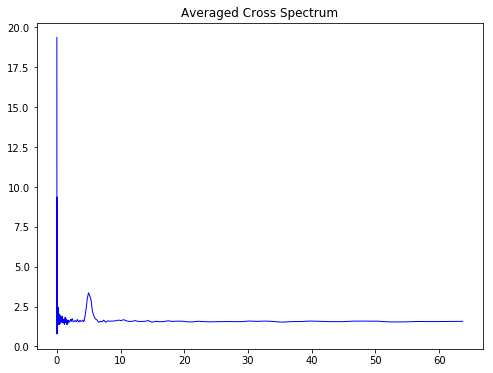

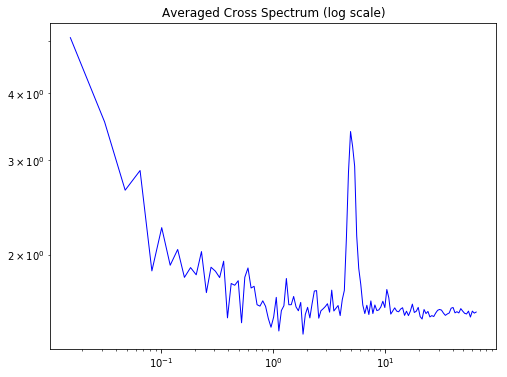

In [6]:
plt.figure(figsize=(8,6))
plt.title("Averaged Cross Spectrum")
plt.plot(cs.freq, np.abs(cs.power), lw=1, color='blue')

plt.figure(figsize=(8,6))
plt.title("Averaged Cross Spectrum (log scale)")
plt.loglog(acs.freq, np.abs(acs.power), lw=1, color='blue')

### Fitting cross spectrum with Astropy models

In [7]:
acs_fitting_model = models.Lorentz1D(amplitude=2, x_0=4.3) + \
                    models.Lorentz1D(amplitude=0.3, x_0=10, fwhm=0.5) + \
                    models.PowerLaw1D() + models.Const1D()

parest, res = fit_crossspectrum(acs, acs_fitting_model, fitmethod="CG")
acs_result_model = res.model
print(acs_result_model)
print(acs_result_model.parameters)

Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Lorentz1D(amplitude=2., x_0=4.3, fwhm=1.)>

    [1]: <Lorentz1D(amplitude=0.3, x_0=10., fwhm=0.5)>

    [2]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
       amplitude_0          x_0_0        ...      alpha_2         amplitude_3    
    ----------------- ------------------ ... ----------------- ------------------
    1.951053671834169 5.0357262894998795 ... 1.005800868989703 1.5566958036974257
[ 1.95105367  5.03572629  0.70958834  0.33430888 10.53287868  0.31629086
  0.11418156  0.4873704   1.00580087  1.5566958 ]


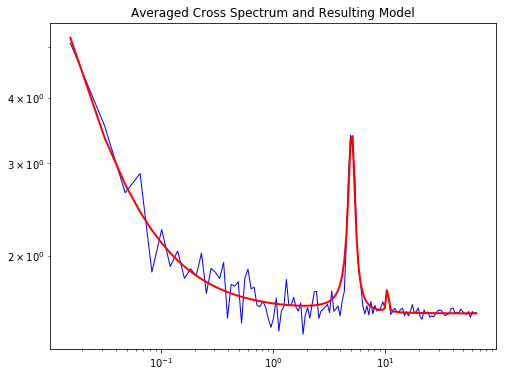

In [8]:
plt.figure(figsize=(8,6))
plt.title("Averaged Cross Spectrum and Resulting Model")
plt.loglog(acs.freq, np.abs(acs.power), lw=1, color='blue')
plt.loglog(acs.freq, np.abs(res.mfit), lw=2, color="red")

### Applying filter on cross spectrum
#### Using optimal filter

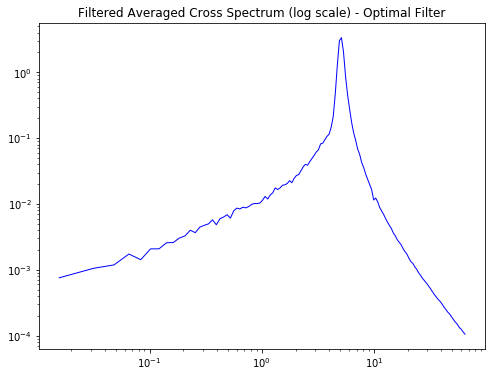

In [9]:
optimal_filter = Optimal1D(acs_result_model)
optimal_filter_freq = optimal_filter(acs.freq)
filtered_acs_power = optimal_filter_freq * np.abs(acs.power)

plt.figure(figsize=(8, 6))
plt.title("Filtered Averaged Cross Spectrum (log scale) - Optimal Filter")
plt.loglog(acs.freq, filtered_acs_power, lw=1, color='blue')

#### Using window function (top hat filter)

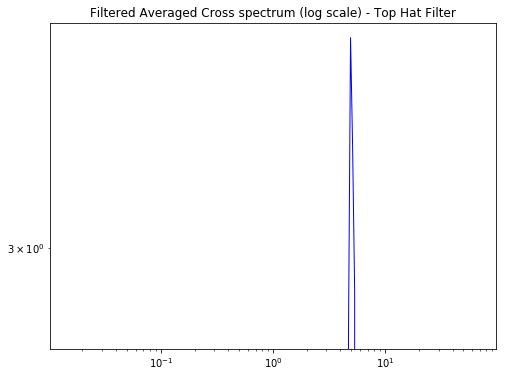

In [10]:
top_hat_filter = Window1D(acs_result_model)
top_hat_filter_freq = top_hat_filter(acs.freq)
filtered_acs_power = top_hat_filter_freq * np.abs(acs.power)

plt.figure(figsize=(8, 6))
plt.title("Filtered Averaged Cross spectrum (log scale) - Top Hat Filter")
plt.loglog(acs.freq, filtered_acs_power, lw=1, color='blue')

## Cross correlation function (CCF)
### Calculation of normalization factor
1. Re-binning of reference band power spectrum
2. Fitting the Lorentzian model
3. Calculate RMS

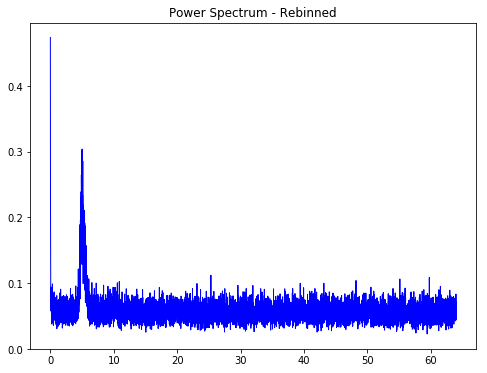

In [11]:
# rebinning power spectrum
new_df = get_new_df(ref_ps, n_bins)
ref_ps_rebinned = ref_ps.rebin(df=new_df)

plt.figure(figsize=(8,6))
plt.title("Power Spectrum - Rebinned")
plt.plot(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned.power), lw=1, color='blue')

In [12]:
# fitting reference band power spectrum
model_to_test = models.Lorentz1D(amplitude=.17, x_0=5., fwhm=0.6) + models.PowerLaw1D(amplitude=0.5) + models.Const1D(amplitude=0.01)
parest, res = fit_powerspectrum(ref_ps_rebinned, model_to_test)
ref_ps_rebinned_result_model = res.model

print(ref_ps_rebinned_result_model)
print(ref_ps_rebinned_result_model.parameters)

Model: CompoundModel5
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Lorentz1D(amplitude=0.17, x_0=5., fwhm=0.6)>

    [1]: <PowerLaw1D(amplitude=0.5, x_0=1., alpha=1.)>

    [2]: <Const1D(amplitude=0.01)>
Parameters:
        amplitude_0           x_0_0       ...      alpha_1           amplitude_2    
    ------------------- ----------------- ... ------------------ -------------------
    0.17526695987447552 5.074570435492063 ... 1.0339949392046546 0.05529564106667318
[1.75266960e-01 5.07457044e+00 5.68615812e-01 2.81177289e-03
 8.29229541e-01 1.03399494e+00 5.52956411e-02]


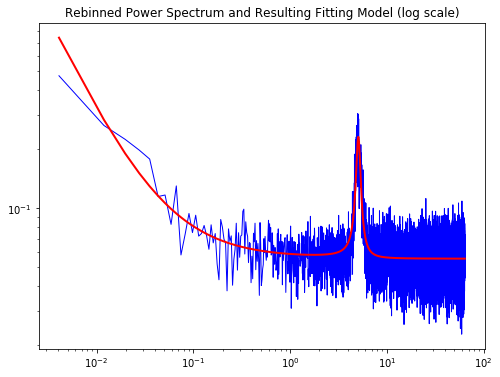

In [13]:
plt.figure(figsize=(8, 6))
plt.title("Rebinned Power Spectrum and Resulting Fitting Model (log scale)")
plt.loglog(ref_ps_rebinned.freq, np.abs(ref_ps_rebinned.power), lw=1, color='blue')
plt.loglog(ref_ps_rebinned.freq, np.abs(res.mfit), lw=2, color="red")

In [14]:
# calculating rms from power spectrum
ref_ps_rebinned_rms = compute_rms(ref_ps_rebinned, ref_ps_rebinned_result_model, criteria="optimal")

# calculating normalized ccf
ccf_norm = ccf(filtered_acs_power, ref_ps_rebinned_rms, n_bins)

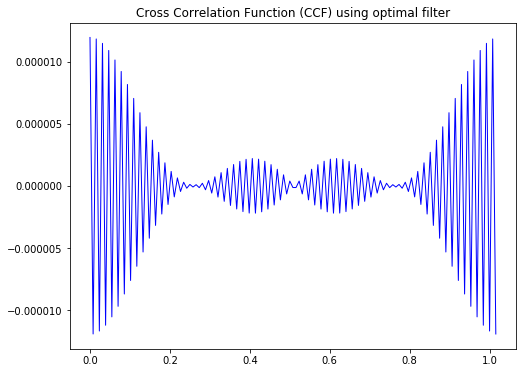

In [15]:
# plotting ccf
ccf_times = np.arange(0, len(ccf_norm)*dt, dt) # x-axis
plt.figure(figsize=(8, 6))
plt.title("Cross Correlation Function (CCF) using optimal filter")
plt.plot(ccf_times, ccf_norm, lw=1, color='blue')

### CCF Error

In [16]:
error, _ = ccf_error(ref_counts, ci_counts_0, acs_result_model, rebin_log_factor, meta, ref_ps_rebinned_rms, filter_type="optimal")
error

array([1.39483703e-07, 1.38619778e-07, 1.37850854e-07, 1.36744169e-07,
       1.35217111e-07, 1.33951756e-07, 1.32854508e-07, 1.31740234e-07,
       1.29904895e-07, 1.27177739e-07, 1.25278142e-07, 1.23324968e-07,
       1.21804169e-07, 1.21110128e-07, 1.21627470e-07, 1.21708734e-07,
       1.20829869e-07, 1.20652646e-07, 1.20439836e-07, 1.19733885e-07,
       1.21200002e-07, 1.23343531e-07, 1.25481901e-07, 1.26452353e-07,
       1.27493278e-07, 1.29355993e-07, 1.30144962e-07, 1.29371671e-07,
       1.29729987e-07, 1.31516945e-07, 1.31532592e-07, 1.30922604e-07,
       1.30468128e-07, 1.29245085e-07, 1.29720993e-07, 1.27103540e-07,
       1.23243959e-07, 1.23375384e-07, 1.24258724e-07, 1.23490376e-07,
       1.22968125e-07, 1.24314388e-07, 1.25896065e-07, 1.26718097e-07,
       1.27273562e-07, 1.29121186e-07, 1.30566504e-07, 1.31858002e-07,
       1.31918524e-07, 1.32062180e-07, 1.31724839e-07, 1.29931206e-07,
       1.28105345e-07, 1.25787085e-07, 1.21722813e-07, 1.16220393e-07,
      